In [2]:
from pipeline_utils import *
import pandas as pd
import numpy as np
import datetime
import re
import collections
import os
import seaborn as sns
import graphviz
import scikitplot as skplt
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import svm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, precision_recall_curve
from sklearn import ensemble 
from sklearn import neighbors
import functools
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.lines as lines
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
get_ipython().magic('matplotlib inline')

# HW 3
The 2014 KDD Cup asks participants to help DonorsChoose.org identify projects that are exceptionally exciting to the business, at the time of posting. This notebook solves and evaluates the solution to this problem in a variety of ways. Our project goal is to predict at time of posting if the project will be fully funded. 

## Step 0: Defining constants for the notebook

In [3]:
Y_PRED_VAR = 'fully_funded'

In [4]:
HYPERPARAM_TUNING = {
    'random_forest': {'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 100, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]},
    'svm': {'C': [1.0, 1.5, 2.0],
           'kernel': ['linear', 'poly']},
    'knn': {'n_neighbors': [2, 5, 7, 9]},
    'decision_tree': {'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 100, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]},
    'boosting': {'n_estimators': [50, 30, 10],
                'learning_rate': [0.5, 1, 1.5]}, 
    'bagging': {'n_estimators': [5, 10, 15], 
               'max_samples': [0.2, 0.6, 1.0],
               'max_features': [0.2, 0.6, 1.0]}
         }

In [6]:
# hyperparameter optimization
tuning_list = ['random_forest', 'boosting', 'bagging', 'knn', 'decision_tree']
desired_metric = 'roc_auc'

CV_NUM = 5
N_ITER = 5

In [7]:
SKLEARN_BASE_MODELS = {
    'logistic_regression': linear_model.LogisticRegressionCV(), 
    'knn': neighbors.KNeighborsClassifier(),
    'decision_tree': tree.DecisionTreeClassifier(), 
    'random_forest': ensemble.RandomForestClassifier(), 
    'svm': svm.SVC(), 
    'boosting': ensemble.AdaBoostClassifier(),
    'bagging': ensemble.BaggingClassifier()
}    

In [8]:
EVALUATION_METHODS = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall'] 
THRESHOLDS_TO_TEST = [0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.50]
CLF_TO_CREATE = ['logistic_regression','bagging', 'boosting', 'decision_tree', 'random_forest', 'knn']#, 'svm']
TESTING_PERIOD = '6M'

In [9]:
STARTDATE = datetime.datetime.strptime('2011-01-01', '%Y-%m-%d')
ENDDATE = datetime.datetime.strptime('2013-12-31', '%Y-%m-%d')

## Step 1: Read in the data

In [10]:
outcomes = read_data('./outcomes.csv')
projects = read_data('./projects.csv')

### Filter out data that is not in our desired year range (2011 - 2013) using a boolean mask

In [11]:
projects['date_posted'] = pd.to_datetime(projects['date_posted'])
mask = (projects['date_posted'] >= STARTDATE) & (projects['date_posted'] <= ENDDATE)
projects = projects.loc[mask]

### Join the data

In [12]:
combined_df = projects.set_index('projectid').join(
    outcomes.set_index('projectid')).reset_index()

### Identify primary columns and remove extra IDs that won't be predictive and information that won't be available at time of project 

In [13]:
combined_df_explor = combined_df[['projectid','school_latitude', 'school_longitude', 
       'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'fully_funded']]

## Step 2: Conduct preliminary data analysis
- Retain the dataset that was explored for reference
- I opted to keep describe rather than histograms, with the option of adding histograms. I had to restart my notebook a bunch, and the histograms took a crazy amount of memory up.



Distributions for  school_latitude
count    353151.000000
mean         36.868563
std           4.927417
min          18.249140
25%          33.916387
50%          36.675826
75%          40.680488
max          67.258157
Name: school_latitude, dtype: float64



Distributions for  school_longitude
count    353151.000000
mean        -95.398318
std          18.118360
min        -171.690554
25%        -117.246823
50%         -89.886438
75%         -80.761902
max         -66.628036
Name: school_longitude, dtype: float64



Distributions for  school_city
count          353151
unique           7724
top       Los Angeles
freq            15444
Name: school_city, dtype: object



Distributions for  school_state
count     353151
unique        51
top           CA
freq       77915
Name: school_state, dtype: object



Distributions for  school_zip
count    353151.000000
mean      56301.763713
std       31043.523511
min         410.000000
25%       29388.000000
50%       60613.000000
75%       90007.

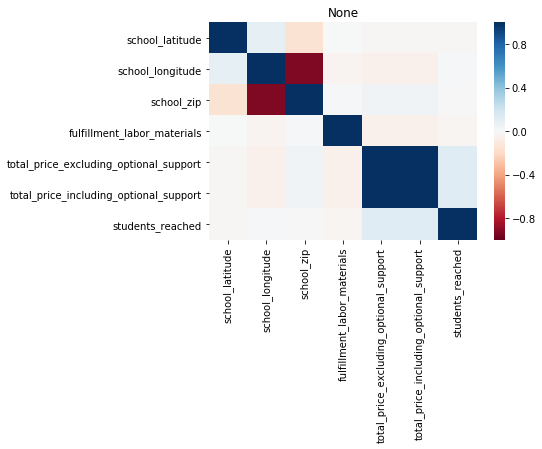

In [14]:
outlier_dict = data_summary_stats(df=combined_df_explor, zparam=2, outlier_threshold=1,
                                  hist_draw=False, ptitle="donors choose correlation")

## Step 3: Clean up the dataset
- Replace values (t, f) with (1, 0)
- Create categorical dummies for any variable with <100 potential options
- Fill numerical missing values with the median (typically 0 for boolean)
- Fill remaining missing values with 0
- Copy the final dataset into a final dataset
- For the purposes of this exercise, outliers were retained (none seemed too extreme) and all missing values were imputed similarly (although the functionality to impute specific columns exists)

### Replace t and f with 1 and 0, respectively

In [15]:
combined_df_filled = combined_df_explor.copy()
for col in combined_df_filled.columns:
    combined_df_filled[col].replace('f',0, inplace=True)
    combined_df_filled[col].replace('t',1, inplace=True)

### Make dummies for any categorical with <100 options

In [16]:
for col in combined_df_filled.columns:
    if combined_df_filled[col].dtype == 'object' and len(combined_df_filled[col].unique()) <= 100:
        combined_df_filled = make_categorical_dummy(df=combined_df_filled, cat=col)

### Impute all columns of missing data with the mean

In [17]:
combined_df_filled = fill_values(df=combined_df_filled, fill_missing_method='median')
combined_df_filled.fillna(0, inplace=True)

In [18]:
combined_df_final = combined_df_filled.copy()

## Step 4: Feature generation
To narrow down features:
- Ridge regression (cross validated so there is no need for hyper-parameter tuning)
- Lasso regression (cross validated so there is no need for hyper-parameter tuning)
- Random Forest Classification (default parameters used)
- Keep the intersection of features retained in all three sets

### Random forest features: retained if importance > 0

In [19]:
rf_feature_list = rf_features(df=combined_df_final, var_excl=['object', 'datetime64[ns]'], 
                              y_pred=Y_PRED_VAR, n_jobs=10, random_state=0)

rf_feature_names = [x for (x,y) in rf_feature_list]

### Lasso CV features: retained if coeff != 0 
- convergence error is an artifact of the data.

In [20]:
lcv_feature_list = lcv_features(df=combined_df_final, y_pred=Y_PRED_VAR, 
                                var_excl=['object', 'datetime64[ns]'], features=None)

lcv_feature_names = [x for (x,y) in lcv_feature_list]

/Users/emmanechamkin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Ridge CV features: retained if coeff != 0 

In [21]:
rcv_feature_list = rcv_features(df=combined_df_final, y_pred=Y_PRED_VAR, 
                                var_excl=['object', 'datetime64[ns]'], features=None)

rcv_feature_names = [x for (x,y) in rcv_feature_list]

### Determine intersection of features for the regression

In [22]:
all_features_retain = set(rf_feature_names).intersection(lcv_feature_names).intersection(rcv_feature_names)

In [23]:
print(all_features_retain, end = " ")

{'primary_focus_subjectEconomics', 'school_stateCA', 'school_metrorural', 'poverty_levelhigh poverty', 'school_stateCO', 'school_charter_ready_promise', 'school_stateNV', 'primary_focus_areaMath & Science', 'resource_typeTechnology', 'school_metrourban', 'primary_focus_subjectHealth & Life Science', 'school_stateWA', 'school_stateTN', 'school_stateNE', 'students_reached', 'school_stateKS', 'poverty_levelhighest poverty', 'primary_focus_subjectMusic', 'teacher_ny_teaching_fellow', 'school_stateDC', 'primary_focus_areaMusic & The Arts', 'secondary_focus_subjectNutrition', 'school_stateIA', 'school_year_round', 'school_stateHI', 'primary_focus_subjectNutrition', 'school_stateMI', 'school_metrosuburban', 'school_stateNC', 'fulfillment_labor_materials', 'primary_focus_subjectGym & Fitness', 'school_stateNY', 'resource_typeBooks', 'primary_focus_subjectEarly Development', 'secondary_focus_subjectMusic', 'school_stateAR', 'eligible_double_your_impact_match', 'teacher_prefixMrs.', 'school_stat

## Step 5: Hyperparameter tuning
- on one test-train split of the data, find the optimal hyperparameters by using a randomized search
- although this model is not tested, having a test-train split will enable future functionality of the tuned models (e.g., if I wanted to, I could get testing results as well). 
- I ran hyperparameter tuning with 5 folds and 2 iterations, largely because my kernel crashed and I wanted to get this done quickly :) ideally, I would run it on 5 folds and 30 or more iterations. 

### Get hyperparameters

In [24]:
# I am not tuning all of the hyperparameters because knn and svm are extremely slow. 
# I did play with them manually in scratch.  
final_params = get_hyper_params(df=combined_df_final, feature_list=list(all_features_retain), y_column=Y_PRED_VAR, 
                                base_models_dict=SKLEARN_BASE_MODELS, random_state=0, 
                                model_list=tuning_list, scoring_mech=desired_metric, 
                                hyperparam_tuning_dict=HYPERPARAM_TUNING, cv=CV_NUM, n_iter=N_ITER)

## Step 6: Generating testing and training time series sets and then conducting modeling
- note, a time period of 12M was used because this was taking forever to run... 6M is better and will be used for analysis
- no buffer time zone was used - this data does not have longer term impact that might bleed from testing into training

In [25]:
series_start = combined_df_final.date_posted.min()
series_end = combined_df_final.date_posted.max()

time_starts = generate_time_points(series_start=series_start, series_end=series_end, period=TESTING_PERIOD)
time_dfs = wrap_single_split(df=combined_df_final, time_col='date_posted', times=time_starts)

### build and evaluate models for each
- note, I've removed SVM and kNN largely because each model takes a substantial amount of time to run. Even with just two test / train sets, the models are infeasible to run right now. The code here is fully functional and the models will be included in my writeup, just not in the notebook at present. 

In [26]:
r = setup_return_dict(threshold_list=THRESHOLDS_TO_TEST, type_list=EVALUATION_METHODS)

In [27]:
rdf, models = cycle_through(time_dfs, clf_list=CLF_TO_CREATE, r=r, param_dict=final_params,
                    features=list(all_features_retain), y_column=Y_PRED_VAR, 
                   threshold_list=THRESHOLDS_TO_TEST, type_list=EVALUATION_METHODS)   

running bagging model...
running boosting model...
running logistic regression model...
running bagging model...
running boosting model...
running logistic regression model...
running bagging model...
running boosting model...
running logistic regression model...
running bagging model...
running boosting model...
running logistic regression model...


In [28]:
rdf

,model,train_start,train_end,test_start,test_end,test_baseline,params,accuracy at 0.01,f1 at 0.01,roc_auc at 0.01,precision at 0.01,recall at 0.01,accuracy at 0.02,f1 at 0.02,roc_auc at 0.02,precision at 0.02,recall at 0.02,accuracy at 0.05,f1 at 0.05,roc_auc at 0.05,precision at 0.05,recall at 0.05,accuracy at 0.1,f1 at 0.1,roc_auc at 0.1,precision at 0.1,recall at 0.1,accuracy at 0.2,f1 at 0.2,roc_auc at 0.2,precision at 0.2,recall at 0.2,accuracy at 0.3,f1 at 0.3,roc_auc at 0.3,precision at 0.3,recall at 0.3,accuracy at 0.5,f1 at 0.5,roc_auc at 0.5,precision at 0.5,recall at 0.5
0,bagging,2011-01-31,2011-07-31,2011-07-31,2012-01-31,0.753320,default,0.753688,0.858059,0.512766,0.758152,0.988295,0.753688,0.858059,0.512766,0.758152,0.988295,0.753688,0.858059,0.512766,0.758152,0.988295,0.753719,0.858072,0.512849,0.758183,0.988275,0.749302,0.851899,0.535881,0.767516,0.957129,0.737632,0.838486,0.566746,0.781797,0.904039,0.662935,0.761703,0.609357,0.814793,0.715109
1,bagging,2011-01-31,2011-07-31,2011-07-31,2012-01-31,0.753320,default,0.754102,0.858244,0.513773,0.758536,0.988132,0.754102,0.858244,0.513773,0.758536,0.988132,0.754102,0.858244,0.513773,0.758536,0.988132,0.754087,0.858234,0.513762,0.758532,0.988112,0.751265,0.852931,0.539526,0.768982,0.957455,0.737310,0.837849,0.569313,0.783043,0.900904,0.659945,0.758250,0.610675,0.816281,0.707923
2,logistic_regression,2011-01-31,2011-07-31,2011-07-31,2012-01-31,0.753320,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.754685,0.859859,0.503770,0.754725,0.999023,0.754777,0.859862,0.504312,0.754928,0.998677,0.754992,0.859845,0.505792,0.755484,0.997659,0.754608,0.859360,0.507524,0.756140,0.995216,0.754961,0.858837,0.514113,0.758658,0.989496,0.755942,0.856636,0.538261,0.768304,0.967918,0.704892,0.799303,0.627673,0.819490,0.780087
3,bagging,2011-01-31,2012-01-31,2012-01-31,2012-07-31,0.673208,default,0.674122,0.804313,0.504150,0.675048,0.994808,0.674122,0.804313,0.504150,0.675048,0.994808,0.674122,0.804313,0.504150,0.675048,0.994808,0.674099,0.804297,0.504133,0.675041,0.994774,0.675492,0.802519,0.514395,0.679737,0.979436,0.674830,0.797092,0.529658,0.687250,0.948726,0.655617,0.764037,0.564149,0.709106,0.828192
4,bagging,2011-01-31,2012-01-31,2012-01-31,2012-07-31,0.673208,default,0.674282,0.804396,0.504377,0.675149,0.994842,0.674282,0.804396,0.504377,0.675149,0.994842,0.674282,0.804396,0.504377,0.675149,0.994842,0.674282,0.804396,0.504377,0.675149,0.994842,0.675424,0.802425,0.514488,0.679782,0.979063,0.675447,0.797572,0.530062,0.687429,0.949744,0.652282,0.761938,0.559909,0.706684,0.826564
5,logistic_regression,2011-01-31,2012-01-31,2012-01-31,2012-07-31,0.673208,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.673254,0.804687,0.500160,0.673278,0.999830,0.673276,0.804698,0.500195,0.673294,0.999830,0.673299,0.804671,0.500356,0.673364,0.999593,0.673299,0.804644,0.500446,0.673404,0.999423,0.673276,0.804543,0.500716,0.673524,0.998846,0.673368,0.804458,0.501288,0.673776,0.998032,0.677708,0.802663,0.520861,0.682769,0.973633
6,bagging,2011-01-31,2012-07-31,2012-07-31,2013-01-31,0.741089,default,0.728265,0.837707,0.525221,0.751460,0.946318,0.728265,0.837707,0.525221,0.751460,0.946318,0.728265,0.837707,0.525221,0.751460,0.946318,0.728265,0.837707,0.525221,0.751460,0.946318,0.696614,0.805597,0.555445,0.767053,0.848219,0.651708,0.756025,0.580505,0.786092,0.728173,0.539746,0.606211,0.597211,0.828313,0.478033
7,bagging,2011-01-31,2012-07-31,2012-07-31,2013-01-31,0.741089,default,0.726716,0.836593,0.524420,0.751151,0.943967,0.726716,0.836593,0.524420,0.751151,0.943967,0.726716,0.836593,0.524420,0.751151,0.943967,0.726716,0.836593,0.524420,0.751151,0.943967,0.694559,0.803789,0.555218,0.767070,0.844200,0.650367,0.754353,0.581435,0.786896,0.724395,0.534026,0.597263,0.597151,0.830725,0.466235
8,logistic_regression,2011-01-31,2012-07-31,2012-07-31,2013-01-31,0.741089,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.741715,0.851506,0.501901,0.741820,0.999256,0.741700,0.851417,0.502471,0.742040,0.9

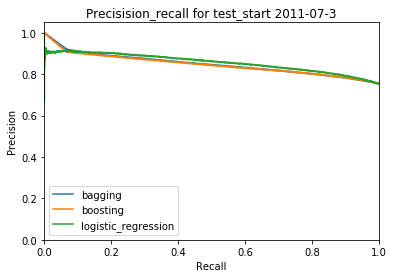

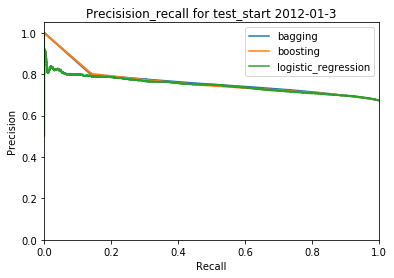

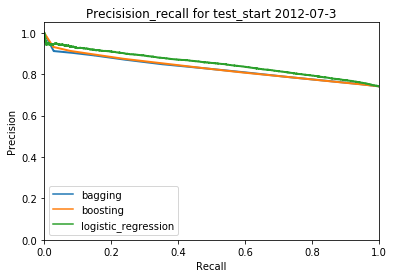

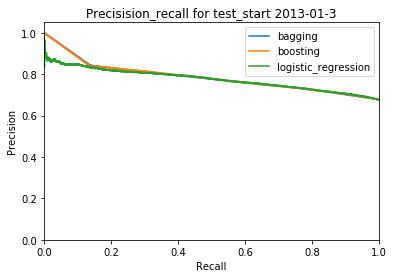

In [38]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 
              'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan']

plot_precision_recall(model_dict=models, color_list=color_list)

In [33]:
models

{'test_start 2011-07-3': {'bagging': {'model': Pipeline(memory=None,
        steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', BaggingClassifier(base_estimator=None, bootstrap=True,
            bootstrap_features=False, max_features=1.0, max_samples=1.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]), 'y_pred': array([[ 0.8,  0.2],
          [ 0.4,  0.6],
          [ 0.4,  0.6],
          ..., 
          [ 0.7,  0.3],
          [ 0.1,  0.9],
          [ 0.3,  0.7]]), 'y_test': 234249    0
   234250    0
   234251    1
   234252    1
   234253    1
   234254    0
   234255    1
   234256    0
   234257    0
   234258    1
   234259    1
   234260    1
   234261    0
   234262    0
   234263    1
   234264    1
   234265    1
   234266    1
   234267    1
   234268    1
   234269    0
   234270    1
   234271    1
   234272    1
   234273    1
   234274    1
   234275    1
   234276